In [1]:
import numpy as np
import GPy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from random import randrange, uniform
from scipy.stats import norm
import math
import copy
import os

from botorch.test_functions import Ackley
from botorch.test_functions import Beale
from botorch.test_functions import Branin
from botorch.test_functions import EggHolder
from botorch.test_functions import Hartmann
from botorch.test_functions import Levy
from botorch.test_functions import Griewank
from botorch.test_functions import Powell
from botorch.test_functions import Shekel
from botorch.test_functions import Rosenbrock
from botorch.test_functions import StyblinskiTang

import torch

from scipy.optimize import minimize, brute
from scipy.stats import norm



class GP_ObjectiveFunction:  
    def __init__(self,dim=2,lengthscale=1.2,variance=10,seed=0):
      self.dim = dim
      self.lengthscale = lengthscale
      self.variance = variance
      self.bounds = np.array([[0,6]]*dim)
      self.init_num = 80**dim

      np.random.seed(seed) 

      X_start = np.random.uniform(self.bounds[:, 0], self.bounds[:, 1],size=(1,dim))
      temp = float(np.random.normal(0, 1, size=1))
      Y_start=np.array([[temp]])

      kernel = GPy.kern.RBF(input_dim=dim,variance=variance,lengthscale=lengthscale)
      m_start = GPy.models.GPRegression(X_start,Y_start,kernel)
      m_start.Gaussian_noise.variance.fix(0.0)

      X_init = np.random.uniform(self.bounds[:, 0], self.bounds[:, 1],size=(self.init_num ,dim))
      Y_init = m_start.posterior_samples_f(X_init.reshape(-1,dim),size=1)

      kernel = GPy.kern.RBF(input_dim=dim,variance=variance,lengthscale=lengthscale)
      m_init = GPy.models.GPRegression(X_init.reshape(-1,dim),Y_init.reshape(-1,1),kernel)
      m_init.Gaussian_noise.variance.fix(0.0)

      self.GP = m_init

      X_check_max = np.random.uniform(self.bounds[:, 0], self.bounds[:, 1],size=((5100+900**dim),dim))
      mean_check_max,_ = self.GP.predict(X_check_max.reshape(-1,self.dim),include_likelihood=False)
      max = np.max(mean_check_max)
      self.max = max

    def __call__(self, X):

        mean,_ = self.GP.predict(X.reshape(-1,self.dim),include_likelihood=False)

        return mean

# Define my functions

In [2]:
def high_dimensional_discretization(bounds,N=800): #bounds shoud always be two dimensional, N is the number of partition in one dimension

  dim = bounds.shape[0]


  bounds = bounds.reshape(dim,-1)
  coords = [np.linspace(bounds[d][0], bounds[d][1], N) for d in range(dim)]
  mesh = np.meshgrid(*coords, indexing='ij')

  coords = np.vstack([x.flatten() for x in mesh]).T

  return coords

In [3]:
def EI(X,dim,f_best,model): # X is a 2-dimensional array because we will use it in scipy.minimize

  #model_temp = copy.deepcopy(model)
  X = X.reshape(-1,dim)

  mean,var = model.predict(X,include_likelihood=False)
  
  # var[var<10**(-12)]=10**(-12)

  z = (mean - f_best)/np.sqrt(var)        
  out=(mean - f_best) * norm.cdf(z) + np.sqrt(var) * norm.pdf(z)

  return out.ravel()  #make the shape to be 1 dimensional



def EI_acquisition_opt(model,bounds,f_best): #bound should an array of size dim*2
  dim = bounds.shape[0]
  
  if dim == 1:
    N = 400
  elif dim == 2:
    N = 41
  
  X_total = high_dimensional_discretization(bounds,N=N)
  AF = EI(X_total,dim,f_best,model)
  X_next = X_total[np.argmax(AF)]


  return X_next



def MES(X,dim,fstar,model): # X is a 2-dimensional array because we will use it in scipy.minimize
  
  X = X.reshape(-1,dim)
  mean,var = model.predict(X,include_likelihood=False)

  # var[var<10**(-12)]=10**(-12)
  gamma = (fstar-mean)/np.sqrt(var)  

  cdf_part = norm.cdf(gamma)
  #print(cdf_part)
  #cdf_part[cdf_part<10**(-300)]=10**(-300)

  out = (gamma*norm.pdf(gamma))/(2*cdf_part)-np.log(cdf_part)

  return out.ravel() 



def MES_acquisition_opt(model,bounds,fstar): #bound should an array of size dim*2
  
  dim = bounds.shape[0]
  
  if dim == 1:
    N = 400
  elif dim == 2:
    N = 41
  
  X_total = high_dimensional_discretization(bounds,N=N)
  AF = MES(X_total,dim,fstar,model)
  X_next = X_total[np.argmax(AF)]
  




  return X_next




def FindMax(X,dim,fstar,model): # X is a 2-dimensional array because we will use it in scipy.minimize
  
  X = X.reshape(-1,dim)
  mean,var = model.predict(X,include_likelihood=False)

  # var[var<10**(-12)]=10**(-12)
  gamma = (fstar-mean)/np.sqrt(var)  

  out = norm.pdf(gamma)

  return out.ravel() 

def FindMax_acquisition_opt(model,bounds,fstar): #bound should an array of size dim*2

  dim = bounds.shape[0]
  if dim == 1:
    N = 400
  elif dim == 2:
    N = 41
  
  X_total = high_dimensional_discretization(bounds,N=N)
  AF = FindMax(X_total,dim,fstar,model)
  X_next = X_total[np.argmax(AF)]


  return X_next

In [92]:
from scipy.signal import find_peaks
from scipy.signal import argrelextrema
from scipy import ndimage

def PI_max(X_temp,research_length,fstar,model_fantasy,bounds): # X is a 2-dimensional array because we will use it in scipy.minimize
    
  ########################## local search ############################  
  dim = bounds.shape[0]
  
  num_sample = 100

  if dim == 1:
    N = 400
  elif dim ==2:
    N = 30
  elif dim ==3:
    N = 12  

  if research_length == 0: 
    res = 0

  else:
      
    lower_before = X_temp-research_length 
    upper_before = X_temp+research_length

    lower_after = np.maximum(lower_before,bounds[:,0]).reshape(-1)
    upper_after = np.minimum(upper_before,bounds[:,1]).reshape(-1)

    new_bounds = np.array([lower_after.tolist(),upper_after.tolist()]).T  #make sure the bounds are two-dimensional

    # print(new_bounds)
    # print('shape:',new_bounds.shape)

    if len(new_bounds.shape) != 2:     # dimension check
      print('check your bounds dimension!')  

    
    X = high_dimensional_discretization(new_bounds,N=N)    # shape is (-1,dim)
    X = X.reshape(-1,dim)


    samples = model_fantasy.posterior_samples_f(X,size=num_sample).reshape(-1,num_sample)
    check = np.any(samples > fstar, axis=0)

    check = check+0.
    res = np.mean(check)

  return res 


def PO(X,research_length,dim,fstar,model,bounds,train_x,train_obj): # X is a 2-dimensional array because we will use it in scipy.minimize

  X = X.reshape(-1,dim)
  mean,var = model.predict(X,include_likelihood=False)
  #var[var<10**(-12)]=10**(-12)
  gamma = (fstar-mean)/np.sqrt(var)  
  P_max = norm.pdf(gamma)

  PNI_holder = []


  model_fantasy = model.copy() 

  for X_temp in X:

    #print("X_temp is:",X_temp)


    new_X = X_temp.reshape(-1,dim)
    new_Y = np.array([[float(fstar)]]) 
    train_x_fantasy = np.concatenate((train_x, new_X))
    train_obj_fantasy = np.concatenate((train_obj, new_Y))

    model_fantasy.set_XY(X=train_x_fantasy.reshape(-1,dim), Y=train_obj_fantasy.reshape(-1,1))

    #model_fantasy = model.condition_on_observations(X=new_X, Y=new_Y,noise=noise.expand_as(new_Y))
    PI = PI_max(X_temp=new_X,research_length=research_length,fstar=fstar,model_fantasy=model_fantasy,bounds=bounds)


    PNI_holder.append(1-PI)



  return  (np.array(PNI_holder).reshape(-1,1)*P_max).ravel()



def PO_acquisition_opt(model,bounds,fstar,research_length,train_x,train_obj): # new 

  dim = bounds.shape[0]
  
  if dim == 1:
    N = 400
  elif dim == 2:
    N = 40
  
  X_total = high_dimensional_discretization(bounds,N=N)
  AF = FindMax(X_total,dim,fstar,model)

  local_maxima = ndimage.filters.maximum_filter(AF, size=3, mode='constant', cval=0)
  # Create a binary mask indicating the locations of the local maxima
  local_maxima_mask = (AF == local_maxima) & (AF > 0.0001)
  X_total = X_total.reshape(-1,dim)
  # Print the binary mask
  local_max = X_total[local_maxima_mask]
  print('local maximum x are: ',local_max)
  Max_local_PO = PO(local_max,research_length,dim,fstar,model,bounds,train_x,train_obj)
  max_candidate = local_max[np.argmax(Max_local_PO)]
  max_candidate_val = np.max(Max_local_PO)
  
  
  local_minima = ndimage.filters.maximum_filter(-AF, size=3, mode='constant', cval=0)
  # Create a binary mask indicating the locations of the local maxima
  local_minima_mask = (AF == local_minima) & (AF > 0.0001)
 
  # Print the binary mask
  local_min = X_total[local_minima_mask]
  print('local minimal x are: ',local_min)
  if len(local_min)>0:
    Min_local_PO = PO(local_min,research_length,dim,fstar,model,bounds,train_x,train_obj)
    min_candidate = local_min[np.argmax(Min_local_PO)]
    min_candidate_val = np.max(Min_local_PO)
  else:
    min_candidate_val = 0.
  
  if max_candidate_val>=min_candidate_val:
    X_next = max_candidate
  else:
    X_next = min_candidate
  
  
      

  return X_next

In [4]:
# PNI version !!!!!!!!!!!!!
from scipy.signal import find_peaks
from scipy.signal import argrelextrema
from scipy import ndimage

def PI_max_simple(X_temp,research_length,fstar,model_fantasy,bounds): # X is a 2-dimensional array because we will use it in scipy.minimize
    
  ########################## local search ############################  
  dim = bounds.shape[0]

  if dim == 1:
    N = 400
  elif dim ==2:
    N = 41

  if research_length == 0: 
    res = 0

  else:
      
    lower_before = X_temp-research_length 
    upper_before = X_temp+research_length

    lower_after = np.maximum(lower_before,bounds[:,0]).reshape(-1)
    upper_after = np.minimum(upper_before,bounds[:,1]).reshape(-1)

    new_bounds = np.array([lower_after.tolist(),upper_after.tolist()]).T  #make sure the bounds are two-dimensional

    # print(new_bounds)
    # print('shape:',new_bounds.shape)

    if len(new_bounds.shape) != 2:     # dimension check
      print('check your bounds dimension!')  

    
    X = high_dimensional_discretization(new_bounds,N=N)    # shape is (-1,dim)
    X = X.reshape(-1,dim)

    mean,var = model_fantasy.predict(X,include_likelihood=False)
    #var[var<10**(-12)]=10**(-12)
    z = (mean-fstar)/np.sqrt(var)

    PI_holder = norm.cdf(z)
    res = np.max(PI_holder)

  return res 


def PO_simple(X,research_length,dim,fstar,model,bounds,train_x,train_obj): # X is a 2-dimensional array because we will use it in scipy.minimize

  X = X.reshape(-1,dim)
  mean,var = model.predict(X,include_likelihood=False)
  #var[var<10**(-12)]=10**(-12)
  gamma = (fstar-mean)/np.sqrt(var)  
  P_max = norm.pdf(gamma)

  PNI_holder = []


  model_fantasy = model.copy() 

  for X_temp in X:

    #print("X_temp is:",X_temp)


    new_X = X_temp.reshape(-1,dim)
    new_Y = np.array([[float(fstar)]]) 
    train_x_fantasy = np.concatenate((train_x, new_X))
    train_obj_fantasy = np.concatenate((train_obj, new_Y))

    model_fantasy.set_XY(X=train_x_fantasy.reshape(-1,dim), Y=train_obj_fantasy.reshape(-1,1))

    #model_fantasy = model.condition_on_observations(X=new_X, Y=new_Y,noise=noise.expand_as(new_Y))
    PI = PI_max_simple(X_temp=new_X,research_length=research_length,fstar=fstar,model_fantasy=model_fantasy,bounds=bounds)


    PNI_holder.append(1-PI)



  return  (np.array(PNI_holder).reshape(-1,1)*P_max).ravel()



def PO_acquisition_opt_simple(model,bounds,fstar,research_length,train_x,train_obj): # new 

  dim = bounds.shape[0]
  
  if dim == 1:
    N = 400
  elif dim == 2:
    N = 41
  
  X_total = high_dimensional_discretization(bounds,N=N)
  AF = PO_simple(X_total,research_length,dim,fstar,model,bounds,train_x,train_obj)
  X_next = X_total[np.argmax(AF)]
  

  return X_next

In [5]:
def Check_Max_byEI(function,seed=0):
  np.random.seed(seed)
  bounds = function.bounds
  dim = function.dim

  train_x = np.random.uniform(bounds[:, 0], bounds[:, 1],size=(3*dim,dim))
  train_obj = function(train_x) 

  best_value_holder = []
  best_value_holder.append(float(train_obj.max()))

  iter_num = 80*dim

  lengthscale = function.lengthscale
  variance = function.variance

  for iter in range(iter_num):

    #print(iter)

    best_value = best_value_holder[-1]

    train_x = train_x.reshape(-1,dim)
    train_obj = train_obj.reshape(-1,1)


    kernel = GPy.kern.RBF(input_dim=dim,lengthscale=lengthscale,variance=variance)
    model = GPy.models.GPRegression(train_x.reshape(-1,dim),train_obj.reshape(-1,1),kernel)
    model.Gaussian_noise.variance.fix(0.0)
    
    new_point_analytic = EI_acquisition_opt(model,bounds=bounds,f_best=best_value)
    new_point_analytic = new_point_analytic.reshape(-1,dim)
    #print(new_point_analytic)

    new_obj = function(new_point_analytic).reshape(-1,1)   #.unsqueeze(-1) .to(device)


    train_x = np.concatenate((train_x, new_point_analytic))
    train_obj = np.concatenate((train_obj, new_obj))

    best_value = float(train_obj.max())
    best_value_holder.append(best_value)

  return best_value_holder[-1]

# Check

1
Optimal solution is:  [0.]


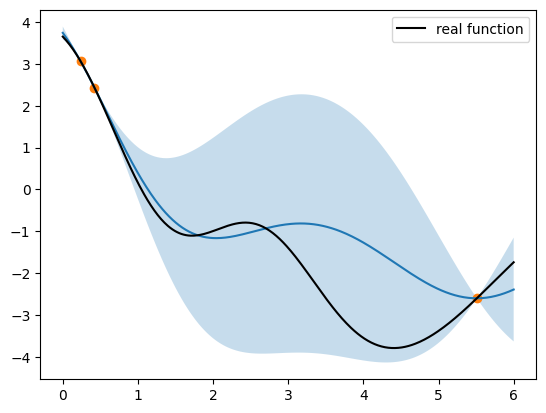

Best FindMax:  [0.03007519]


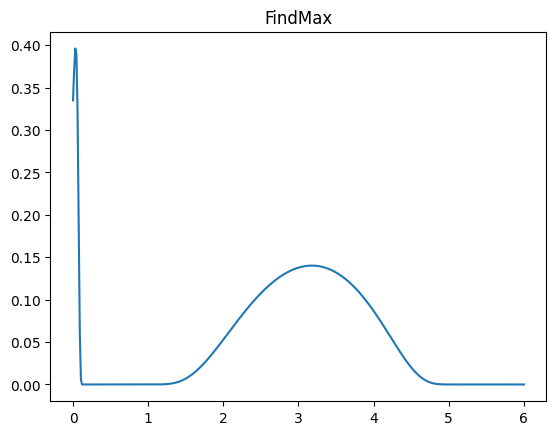

Best PO:  [0.]


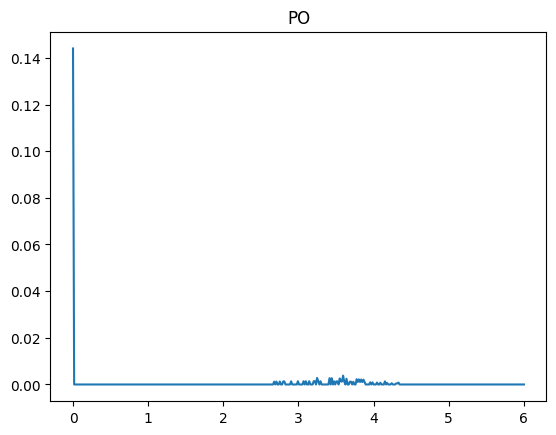

Best MES:  [0.]


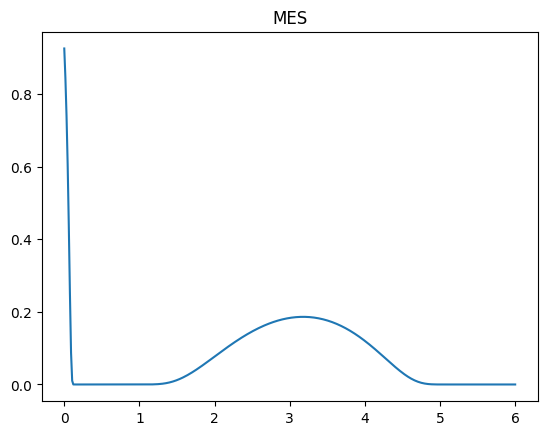

In [51]:
exp = 1
print(exp)
np.random.seed(exp)

research_length = 6

function = GP_ObjectiveFunction(dim=1,seed=exp)
bounds=function.bounds
dim = bounds.shape[0]
fstar =  max(function.max,Check_Max_byEI(function,seed=exp))

X_total = np.linspace(0,6,400)
X_total = X_total.reshape(-1,dim)

lengthscale = function.lengthscale
variance = function.variance

train_x = np.random.uniform(bounds[:, 0], bounds[:, 1],size=(3*dim,dim))
train_obj = function(train_x)  #shape (n,)

train_x = train_x.reshape(-1,dim)
train_obj = train_obj.reshape(-1,1)


kernel = GPy.kern.RBF(input_dim=dim,lengthscale=lengthscale,variance=variance)
model = GPy.models.GPRegression(train_x.reshape(-1,dim),train_obj.reshape(-1,1),kernel)
model.Gaussian_noise.variance.fix(0.0)

mean,var = model.predict(X_total.reshape(-1,1),include_likelihood=False)
std = np.sqrt(var)


Y_total = function(X_total)

plt.plot(X_total,mean)
plt.fill_between(X_total.reshape(-1,), (mean-std).reshape(-1), (mean+std).reshape(-1) ,alpha=0.25)  
plt.plot(X_total,Y_total,label='real function',color='black')
plt.scatter(train_x,train_obj)
plt.legend()
print('Optimal solution is: ', X_total[np.argmax(Y_total)])
plt.show()
plt.close()

FindMax_holder = FindMax(X_total,dim,fstar,model)
MES_holder = MES(X_total,dim,fstar,model)
PO_holder= PO(X_total,research_length,dim,fstar,model,bounds,train_x,train_obj)

plt.plot(X_total,FindMax_holder)
plt.title('FindMax')
print('Best FindMax: ', X_total[np.argmax(FindMax_holder)])
plt.show()
plt.close()

plt.plot(X_total,PO_holder)
plt.title('PO')
print('Best PO: ', X_total[np.argmax(PO_holder)])
plt.show()
plt.close()

plt.plot(X_total,MES_holder)
plt.title('MES')
print('Best MES: ', X_total[np.argmax(MES_holder)])
plt.show()
plt.close()


# EI GP

In [14]:
N = 100
total_record_EI = []

for exp in range(N):

  print(exp)
  np.random.seed(exp)

  function = GP_ObjectiveFunction(dim=2,lengthscale=1.2,seed=exp)
  bounds=function.bounds
  dim = bounds.shape[0]
  
  X_total = high_dimensional_discretization(bounds,N=41)
  Val = function (X_total)
  fstar =  np.max(Val)
  print(fstar)

  train_x = np.random.uniform(bounds[:, 0], bounds[:, 1],size=(3*dim,dim))
  train_obj = function(train_x)  #shape (n,)

  best_value_holder = []
  best_value_holder.append(float(train_obj.max()))

  regret_holder = []
  regret_holder.append(fstar - float(train_obj.max()))

  iter_num = 7*dim

  lengthscale = function.lengthscale
  variance = function.variance

  for iter in range(iter_num):

    #print(iter)

    best_value = best_value_holder[-1]

    train_x = train_x.reshape(-1,dim)
    train_obj = train_obj.reshape(-1,1)


    kernel = GPy.kern.RBF(input_dim=dim,lengthscale=lengthscale,variance=variance)
    model = GPy.models.GPRegression(train_x.reshape(-1,dim),train_obj.reshape(-1,1),kernel)
    model.Gaussian_noise.variance.fix(0.0)
    
    new_point_analytic = EI_acquisition_opt(model,bounds=bounds,f_best=best_value)
    new_point_analytic = new_point_analytic.reshape(-1,dim)
    #print(new_point_analytic)

    new_obj = function(new_point_analytic).reshape(-1,1)   


    train_x = np.concatenate((train_x, new_point_analytic))
    train_obj = np.concatenate((train_obj, new_obj))

    best_value = float(train_obj.max())
    best_value_holder.append(best_value)

    regret = fstar - best_value
    regret_holder.append(regret)

  regret_holder = np.array(regret_holder)
  total_record_EI.append(regret_holder)

0
[8.52814879]
1
[4.41007595]
2
[4.76829143]
3
[2.41259211]
4
[2.74563333]
5
[3.67461704]
6
[4.09210952]
7
[6.7129263]
8
[4.63815181]
9
[3.69329466]
10
[8.25886859]
11
[7.65826024]
12
[4.28728839]
13
[3.12461977]
14
[4.14051482]
15
[5.83921956]
16
[4.87754055]
17
[6.80963595]
18
[4.62597982]
19
[4.42386709]
20
[8.3162221]
21
[6.28808585]
22
[5.41335186]
23
[4.08030689]
24
[7.38784369]
25
[4.91764613]
26
[6.54276031]
27
[5.09644568]
28
[1.54786777]
29
[10.37446316]
30
[3.7473335]
31
[8.29327913]
32
[5.42206296]
33
[2.96353878]
34
[1.15319626]
35
[7.57863381]
36
[1.32527082]
37
[4.69660022]
38
[2.26462923]
39
[2.86535166]
40
[2.69610728]
41
[4.14733817]
42
[1.45915005]
43
[7.12183917]
44
[1.60450231]
45
[5.72455041]
46
[4.86112637]
47
[2.86528869]
48
[8.61653966]
49
[3.21353397]
50
[6.84013013]
51
[9.58030201]
52
[4.8433889]
53
[5.47355023]
54
[6.08214633]
55
[6.1798441]
56
[3.30505605]
57
[6.92788205]
58
[2.13384709]
59
[4.27900729]
60
[6.6344928]
61
[5.44031182]
62
[2.39644935]
63
[2.6

# MES GP

In [13]:
N = 100
total_record_MES = []

for exp in range(N):

  print(exp)
  np.random.seed(exp)

  function = GP_ObjectiveFunction(dim=2,lengthscale=2,seed=exp)
  bounds=function.bounds
  dim = bounds.shape[0]
  
  X_total = high_dimensional_discretization(bounds,N=41)
  Val = function (X_total)
  fstar =  max(Val)
  print(fstar)

  train_x = np.random.uniform(bounds[:, 0], bounds[:, 1],size=(3*dim,dim))
  train_obj = function(train_x)  #shape (n,)

  best_value_holder = []
  best_value_holder.append(float(train_obj.max()))

  regret_holder = []
  regret_holder.append(fstar - float(train_obj.max()))

  iter_num = 7*dim

  lengthscale = function.lengthscale
  variance = function.variance

  for iter in range(iter_num):

    #print(iter)

    best_value = best_value_holder[-1]

    train_x = train_x.reshape(-1,dim)
    train_obj = train_obj.reshape(-1,1)


    kernel = GPy.kern.RBF(input_dim=dim,lengthscale=lengthscale,variance=variance)
    model = GPy.models.GPRegression(train_x.reshape(-1,dim),train_obj.reshape(-1,1),kernel)
    model.Gaussian_noise.variance.fix(0.0)
    
    new_point_analytic = MES_acquisition_opt(model,bounds=bounds,fstar = fstar)
    new_point_analytic = new_point_analytic.reshape(-1,dim)
    print('selected x: ',new_point_analytic)
    
    #print('PO is: ', PO_simple(new_point_analytic,6,dim,fstar,model,bounds,train_x,train_obj))

    #print('selected x: ',new_point_analytic)

    new_obj = function(new_point_analytic).reshape(-1,1)   #.unsqueeze(-1) .to(device)


    train_x = np.concatenate((train_x, new_point_analytic))
    train_obj = np.concatenate((train_obj, new_obj))

    best_value = float(train_obj.max())
    best_value_holder.append(best_value)

    regret = fstar - best_value
    regret_holder.append(regret)

  #print(train_x)
  regret_holder = np.array(regret_holder)
  total_record_MES.append(regret_holder)

0
[8.52814879]
selected x:  [[1.65 6.  ]]
selected x:  [[1.2 6. ]]
selected x:  [[1.95 6.  ]]
selected x:  [[1.95 6.  ]]
selected x:  [[1.95 6.  ]]
selected x:  [[1.95 6.  ]]
selected x:  [[1.95 6.  ]]
selected x:  [[1.95 6.  ]]
selected x:  [[1.95 6.  ]]
selected x:  [[1.95 6.  ]]
selected x:  [[1.95 6.  ]]
selected x:  [[1.95 6.  ]]
selected x:  [[1.95 6.  ]]
selected x:  [[1.95 6.  ]]
1
[4.41007595]
selected x:  [[1.8  0.45]]
selected x:  [[1.2 0.9]]
selected x:  [[1.2 0.6]]
selected x:  [[0.9 0.6]]
selected x:  [[1.35 0.75]]
selected x:  [[1.35 0.75]]
selected x:  [[1.35 0.75]]
selected x:  [[1.35 0.75]]
selected x:  [[1.35 0.75]]
selected x:  [[1.35 0.75]]
selected x:  [[1.35 0.75]]
selected x:  [[1.35 0.75]]
selected x:  [[1.35 0.75]]
selected x:  [[1.35 0.75]]
2
[4.76829143]
selected x:  [[6. 6.]]
selected x:  [[4.8 6. ]]
selected x:  [[6.   4.95]]
selected x:  [[6.  5.1]]
selected x:  [[6.  4.8]]
selected x:  [[6.  4.8]]
selected x:  [[6.  4.8]]
selected x:  [[6.  4.8]]
selecte

# Findmax GP

In [12]:
N = 100
total_record_FindMax = []

for exp in range(N):

  print(exp)
  np.random.seed(exp)

  function = GP_ObjectiveFunction(dim=2,lengthscale=2,seed=exp)
  bounds=function.bounds
  dim = bounds.shape[0]
  
  X_total = high_dimensional_discretization(bounds,N=41)
  Val = function (X_total)
  fstar =  max(Val)
  print(fstar)


  train_x = np.random.uniform(bounds[:, 0], bounds[:, 1],size=(3*dim,dim)) #这里要改一下
  train_obj = function(train_x)  #shape (n,)
  
  #print('initial x are: ',train_x)

  best_value_holder = []
  best_value_holder.append(float(train_obj.max()))

  regret_holder = []
  regret_holder.append(fstar - float(train_obj.max()))

  iter_num = 7*dim

  lengthscale = function.lengthscale
  variance = function.variance

  for iter in range(iter_num):

    #print(iter)

    best_value = best_value_holder[-1]

    train_x = train_x.reshape(-1,dim)
    train_obj = train_obj.reshape(-1,1)


    kernel = GPy.kern.RBF(input_dim=dim,lengthscale=lengthscale,variance=variance)
    model = GPy.models.GPRegression(train_x.reshape(-1,dim),train_obj.reshape(-1,1),kernel)
    model.Gaussian_noise.variance.fix(0.0)
    
    new_point_analytic = FindMax_acquisition_opt(model,bounds=bounds,fstar = fstar)
    new_point_analytic = new_point_analytic.reshape(-1,dim)
    print('selected x: ',new_point_analytic)

    new_obj = function(new_point_analytic).reshape(-1,1)   #.unsqueeze(-1) .to(device)


    train_x = np.concatenate((train_x, new_point_analytic))
    train_obj = np.concatenate((train_obj, new_obj))

    best_value = float(train_obj.max())
    best_value_holder.append(best_value)

    regret = fstar - best_value
    regret_holder.append(regret)

  regret_holder = np.array(regret_holder)
  total_record_FindMax.append(regret_holder)

0
[8.52814879]
selected x:  [[1.65 6.  ]]
selected x:  [[1.2 6. ]]
selected x:  [[1.95 6.  ]]
selected x:  [[1.95 6.  ]]
selected x:  [[1.95 6.  ]]
selected x:  [[1.95 6.  ]]
selected x:  [[1.95 6.  ]]
selected x:  [[1.95 6.  ]]
selected x:  [[1.95 6.  ]]
selected x:  [[1.95 6.  ]]
selected x:  [[1.95 6.  ]]
selected x:  [[1.95 6.  ]]
selected x:  [[1.95 6.  ]]
selected x:  [[1.95 6.  ]]
1
[4.41007595]
selected x:  [[2.4 0. ]]
selected x:  [[0.75 0.3 ]]
selected x:  [[1.2 0.9]]
selected x:  [[1.35 0.6 ]]
selected x:  [[6.  1.2]]
selected x:  [[6. 0.]]
selected x:  [[1.35 0.75]]
selected x:  [[1.35 0.75]]
selected x:  [[1.35 0.75]]
selected x:  [[1.35 0.75]]
selected x:  [[1.35 0.75]]
selected x:  [[1.35 0.75]]
selected x:  [[1.35 0.75]]
selected x:  [[1.35 0.75]]
2
[4.76829143]
selected x:  [[6. 6.]]
selected x:  [[4.8 6. ]]
selected x:  [[6.  5.1]]
selected x:  [[6.  4.8]]
selected x:  [[6.  4.8]]
selected x:  [[6.  4.8]]
selected x:  [[6.  4.8]]
selected x:  [[6.  4.8]]
selected x:  

# PO GP

In [96]:
N = 30
total_record_PO = []

for exp in range(N):

  print(exp)
  np.random.seed(exp)

  function = GP_ObjectiveFunction(dim=2,seed=exp)
  bounds=function.bounds
  dim = bounds.shape[0]
  
  X_total = high_dimensional_discretization(bounds,N=40)
  Val = function (X_total)
  fstar =  max(Val)
  print(fstar)

  train_x = np.random.uniform(bounds[:, 0], bounds[:, 1],size=(4*dim,dim))
  train_obj = function(train_x)  #shape (n,)

  best_value_holder = []
  best_value_holder.append(float(train_obj.max()))

  regret_holder = []
  regret_holder.append(fstar - float(train_obj.max()))

  iter_num = 7*dim

  research_length = 6. # By my experiment, a smaller research_length is better

  lengthscale = function.lengthscale
  variance = function.variance




  # X_total = np.linspace(0,6,400)
  # X_total = X_total.reshape(-1,dim)

  # lengthscale = function.lengthscale
  # variance = function.variance

  # train_x = train_x.reshape(-1,dim)
  # train_obj = train_obj.reshape(-1,1)


  # kernel = GPy.kern.RBF(input_dim=dim,lengthscale=lengthscale,variance=variance)
  # model = GPy.models.GPRegression(train_x.reshape(-1,dim),train_obj.reshape(-1,1),kernel)
  # model.Gaussian_noise.variance.fix(0.0)

  # mean,var = model.predict(X_total.reshape(-1,1),include_likelihood=False)
  # std = np.sqrt(var)


  # Y_total = function(X_total)

  # plt.plot(X_total,mean)
  # plt.fill_between(X_total.reshape(-1,), (mean-std).reshape(-1), (mean+std).reshape(-1) ,alpha=0.25)  
  # plt.plot(X_total,Y_total,label='real function',color='black')
  # plt.scatter(train_x,train_obj)
  # plt.legend()
  # print('Optimal solution is: ', X_total[np.argmax(Y_total)])
  # plt.show()
  # plt.close()
  
  # FindMax_holder = FindMax(X_total,dim,fstar,model)
  # MES_holder = MES(X_total,dim,fstar,model)
  # PO_holder= PO(X_total,research_length,dim,fstar,model,bounds,train_x,train_obj)

  # plt.plot(X_total,FindMax_holder)
  # plt.title('FindMax')
  # print('Best FindMax: ', X_total[np.argmax(FindMax_holder)])
  # plt.show()
  # plt.close()

  # plt.plot(X_total,PO_holder)
  # plt.title('PO')
  # print('Best PO: ', X_total[np.argmax(PO_holder)])
  # plt.show()
  # plt.close()

  # plt.plot(X_total,MES_holder)
  # plt.title('MES')
  # print('Best MES: ', X_total[np.argmax(MES_holder)])
  # plt.show()
  # plt.close()
  
  
  
  
  

  for iter in range(iter_num):

    print(iter)

    best_value = best_value_holder[-1]

    train_x = train_x.reshape(-1,dim)
    train_obj = train_obj.reshape(-1,1)


    kernel = GPy.kern.RBF(input_dim=dim,lengthscale=lengthscale,variance=variance)
    model = GPy.models.GPRegression(train_x.reshape(-1,dim),train_obj.reshape(-1,1),kernel)
    model.Gaussian_noise.variance.fix(0.0)
    
    # if iter == 0:
    #   new_point_analytic = PO_acquisition_opt(model,bounds=bounds,fstar=fstar,research_length=research_length,train_x=train_x,train_obj=train_obj) 
    #   new_point_analytic = new_point_analytic.reshape(-1,dim)
    #   print('x chosen: ',new_point_analytic)
    # else:
    #   new_point_analytic = MES_acquisition_opt(model,bounds=bounds,fstar = fstar) #PO_acquisition_opt_simple(model,bounds=bounds,fstar=fstar,research_length=research_length,train_x=train_x,train_obj=train_obj) 
    #   new_point_analytic = new_point_analytic.reshape(-1,dim)
    #   print('x chosen: ',new_point_analytic)
    
    new_point_analytic = PO_acquisition_opt_simple(model,bounds=bounds,fstar=fstar,research_length=research_length,train_x=train_x,train_obj=train_obj) 
    new_point_analytic = new_point_analytic.reshape(-1,dim)
    print('x chosen: ',new_point_analytic)
    

    new_obj = function(new_point_analytic).reshape(-1,1)   #.unsqueeze(-1) .to(device)
    #rint('y: ',new_obj)

    train_x = np.concatenate((train_x, new_point_analytic))
    train_obj = np.concatenate((train_obj, new_obj))

    best_value = float(train_obj.max())
    best_value_holder.append(best_value)

    regret = fstar - best_value
    regret_holder.append(regret)

  regret_holder = np.array(regret_holder)
  total_record_PO.append(regret_holder)

0
[8.17706519]
0
x chosen:  [[2. 6.]]
1
x chosen:  [[1.84615385 6.        ]]
2
x chosen:  [[1.84615385 6.        ]]
3
x chosen:  [[1.84615385 6.        ]]
4
x chosen:  [[1.84615385 6.        ]]
5
x chosen:  [[1.84615385 6.        ]]
6
x chosen:  [[1.84615385 6.        ]]
7
x chosen:  [[1.84615385 6.        ]]
8
x chosen:  [[1.84615385 6.        ]]
9
x chosen:  [[1.84615385 6.        ]]
10
x chosen:  [[1.84615385 6.        ]]
11
x chosen:  [[1.84615385 6.        ]]
12
x chosen:  [[1.84615385 6.        ]]
13
x chosen:  [[1.84615385 6.        ]]
1
[5.97886301]
0
x chosen:  [[1.38461538 6.        ]]
1
x chosen:  [[1.23076923 5.84615385]]
2
x chosen:  [[1.23076923 6.        ]]
3
x chosen:  [[1.38461538 5.84615385]]
4
x chosen:  [[1.38461538 5.84615385]]
5
x chosen:  [[1.38461538 5.84615385]]
6
x chosen:  [[1.38461538 5.84615385]]
7
x chosen:  [[1.38461538 5.84615385]]
8
x chosen:  [[1.38461538 5.84615385]]
9
x chosen:  [[1.38461538 5.84615385]]
10
x chosen:  [[1.38461538 5.84615385]]
11
x c

In [14]:
total_record_PO

[array([[ 7.98718426e-01],
        [ 7.98718426e-01],
        [-2.84217094e-13],
        [-2.84217094e-13],
        [-2.84217094e-13],
        [-2.84217094e-13],
        [-2.84217094e-13]])]

In [16]:
train_x

array([[2.27002006],
       [2.40749268],
       [3.74668398],
       [6.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [5.222     ]])

# Plotting

Text(0.5, 1.0, 'GP 2D')

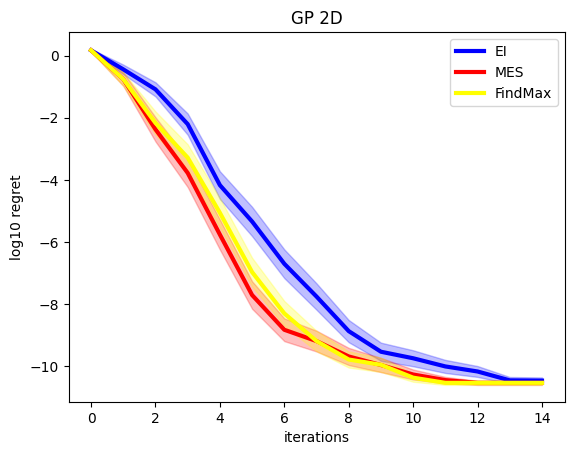

In [15]:
N = 100

total_record = np.array(total_record_EI)
total_record[total_record<=0]=10**(-10)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='blue',label='EI')
plt.fill_between(iter, (mean-std/np.sqrt(N)).reshape(-1,), (mean+std/np.sqrt(N)).reshape(-1,) ,color='blue',alpha=0.25)

total_record = np.array(total_record_MES)
total_record[total_record<=0]=10**(-10)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='red',label='MES')
plt.fill_between(iter, (mean-std/np.sqrt(N)).reshape(-1,), (mean+std/np.sqrt(N)).reshape(-1,) ,color='red',alpha=0.25)

total_record = np.array(total_record_FindMax)
total_record[total_record<=0]=10**(-10)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='yellow',label='FindMax')
plt.fill_between(iter,(mean-std/np.sqrt(N)).reshape(-1,), (mean+std/np.sqrt(N)).reshape(-1,),color='yellow',alpha=0.25)

# total_record = np.array(total_record_PO)
# total_record[total_record<=0]=10**(-9)
# total_record = np.log10(total_record)
# mean = np.mean(total_record,axis=0)
# std = np.std(total_record,axis=0)
# iter = np.array(range(mean.shape[0]))
# plt.plot(mean,linewidth=3,color='black',label='PO')
# plt.fill_between(iter, (mean-std/np.sqrt(N)).reshape(-1,), (mean+std/np.sqrt(N)).reshape(-1,) ,color='black',alpha=0.25)


plt.ylabel('log10 regret')
plt.xlabel('iterations')
plt.legend()
plt.title('GP 2D')  

Text(0.5, 1.0, 'GP 1D')

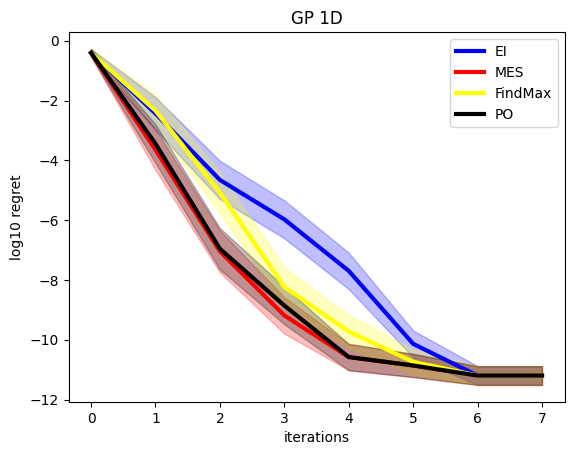

In [72]:
N = 50

total_record = np.array(total_record_EI)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='blue',label='EI')
plt.fill_between(iter, (mean-std/np.sqrt(N)).reshape(-1,), (mean+std/np.sqrt(N)).reshape(-1,) ,color='blue',alpha=0.25)

total_record = np.array(total_record_MES)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='red',label='MES')
plt.fill_between(iter, (mean-std/np.sqrt(N)).reshape(-1,), (mean+std/np.sqrt(N)).reshape(-1,) ,color='red',alpha=0.25)

total_record = np.array(total_record_FindMax)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='yellow',label='FindMax')
plt.fill_between(iter,(mean-std/np.sqrt(N)).reshape(-1,), (mean+std/np.sqrt(N)).reshape(-1,),color='yellow',alpha=0.25)

total_record = np.array(total_record_PO)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='black',label='PO')
plt.fill_between(iter, (mean-std/np.sqrt(N)).reshape(-1,), (mean+std/np.sqrt(N)).reshape(-1,) ,color='black',alpha=0.25)


plt.ylabel('log10 regret')
plt.xlabel('iterations')
plt.legend()
plt.title('GP 1D')  

In [32]:
mean-std/np.sqrt(N)

array([[ -0.56662098],
       [ -2.05392104],
       [ -5.40386847],
       [ -5.65484933],
       [ -8.35925804],
       [ -9.60267671],
       [-10.75044067]])

In [20]:
mean.shape

(7, 1)

In [22]:
iter.shape

(7,)

In [61]:
total_record_MES

[array([1.47984061e+00, 2.65459444e-04, 2.65459444e-04, 2.65459444e-04,
        2.65459444e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 array([ 4.59600607e+00, -1.08822151e-03, -1.08822151e-03, -1.08822151e-03,
        -1.08822151e-03, -1.08822151e-03, -1.08822151e-03, -1.08822151e-03]),
 array([1.39741475, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ]),
 array([5.75305175e-01, 4.77618492e-04, 4.77618492e-04, 4.77618492e-04,
        4.77618492e-04, 4.77618492e-04, 4.77618492e-04, 4.77618492e-04]),
 array([9.12730226e-01, 4.12028860e-01, 4.65184017e-02, 4.65184017e-02,
        4.65184017e-02, 4.05312119e-08, 4.05312119e-08, 4.05312119e-08]),
 array([0.64374475, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ]),
 array([2.70574354e+00, 1.31029950e-01, 1.31029950e-01, 3.54858344e-07,
        3.54858344e-07, 3.54858344e-07, 3.54858344e-07, 3.54858344e-07]),
 array([2.91111615, 2.48166662, 0.

In [60]:
total_record_PO

[array([1.47984061e+00, 1.44705630e+00, 1.32283076e+00, 4.92501714e-06,
        4.92501714e-06, 4.92501714e-06, 4.92501714e-06, 4.92501714e-06]),
 array([ 4.59600607e+00, -1.08822151e-03, -1.08822151e-03, -1.08822151e-03,
        -1.08822151e-03, -1.08822151e-03, -1.08822151e-03, -1.08822151e-03]),
 array([1.39741475, 1.39741475, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ]),
 array([5.75305175e-01, 4.80906940e-04, 4.80906940e-04, 4.80906940e-04,
        4.80906940e-04, 4.80906940e-04, 4.80906940e-04, 4.80906940e-04]),
 array([9.12730226e-01, 4.12028860e-01, 4.65301826e-02, 4.60348174e-05,
        4.60348174e-05, 4.60348174e-05, 4.60348174e-05, 4.60348174e-05]),
 array([0.64374475, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ]),
 array([2.70574354, 2.70574354, 0.07729584, 0.07729584, 0.07729584,
        0.07729584, 0.02135141, 0.02135141]),
 array([2.91111615, 2.48168594, 0.        , 0.        , 0.        

In [57]:
len(total_record_PO)

2